In [1]:
import os
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'
PATH = os.getenv('PATH')
%env PATH=/home/juehang/.conda/envs/numpyro_gpu/bin:$PATH
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = '0.5'

env: PATH=/home/juehang/.conda/envs/numpyro_gpu/bin:/opt/conda/envs/jupyterhub/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [2]:
1

1

In [3]:
from functools import partial
import numpy as np
import scipy.stats as spystats
import corner
import arviz as az
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm

# JAX imports
import jax
from jax import config, jit, lax, random
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy import stats
from jax.scipy.special import ndtri, erf, gammaln, ndtr
from jax.experimental import sparse

# Numpyro and related imports
import numpyro
from numpyro.infer.reparam import LocScaleReparam
from numpyro import infer
import numpyro.distributions as ndist

# Tensorflow Probability (TFP) imports
from tensorflow_probability.substrates import jax as tfp


In [4]:
device_cpu = jax.devices('cpu')[0]
device_gpu = jax.devices('gpu')[1]
jax.config.update("jax_default_device", device_gpu)
numpyro.set_platform('gpu')
numpyro.set_host_device_count(4)

In [5]:
# Global vars
sqrt2 = np.sqrt(2)
inv_sqrt2_PI = 1/np.sqrt(2*jnp.pi)

In [6]:
class SkewNormal(ndist.Distribution):
    """
    Implementation of the Skew Normal distribution.

    Attributes
    ----------
    arg_constraints : dict
        A dictionary indicating the constraints for the distribution parameters.
    support : ndist.constraints.real
        The real value support for the distribution.
    reparametrized_params : list
        List of reparametrized parameters.
    loc : scalar or array, optional
        Location parameter, default is 0.0.
    scale : scalar or array, optional
        Scale parameter, default is 1.0.
    skew : scalar or array, optional
        Skew parameter, default is 0.
    validate_args : bool, optional
        If true, distribution parameters are checked for validity despite possibly degrading runtime performance, default is None.

    Methods
    -------
    __init__(self, loc=0.0, scale=1.0, skew=0, *, validate_args=None)
        Constructor method.
    sample(self, key, sample_shape=())
        Draw samples from the distribution.
    log_prob(self, value)
        Compute the log probability density function at a given point.
    cdf(self, value)
        Compute the cumulative distribution function at a given point.
    log_cdf(self, value)
        Compute the log of the cumulative distribution function at a given point.
    mean(self)
        Compute the expected value of the distribution.
    variance(self)
        Compute the variance of the distribution.

    """

    arg_constraints = {"loc": ndist.constraints.real, "scale": ndist.constraints.positive, "skew": ndist.constraints.real}
    support = ndist.constraints.real
    reparametrized_params = ["loc", "scale"]

    def __init__(self, loc=0.0, scale=1.0, skew=0, *, validate_args=None):
        batch_shape = lax.broadcast_shapes(jnp.shape(loc), jnp.shape(scale), jnp.shape(skew))
        self.loc, self.scale, self.skew = ndist.util.promote_shapes(loc, scale, skew, shape=batch_shape)
        self._delta = self.skew/jnp.sqrt(1 + self.skew**2)
        super(SkewNormal, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )

    def sample(self, key, sample_shape=()):
        assert numpyro.util.is_prng_key(key)
        eps = spystats.skewnorm.rvs(
            self.skew, size=sample_shape + self.batch_shape + self.event_shape, random_state=np.random.RandomState(key)
        )
        return self.loc + eps * self.scale

    @ndist.util.validate_sample
    def log_prob(self, value):
        normalize_term = jnp.log(0.5*jnp.sqrt(2 * jnp.pi) * self.scale)
        value_scaled = (value - self.loc) / self.scale
        return -0.5 * value_scaled**2 - normalize_term + stats.norm.logcdf(self.skew*value_scaled)

    def cdf(self, value):
        scaled = (value - self.loc) / self.scale
        return ndtr(scaled) - 2*tfp.math.owens_t(scaled, self.skew)

    def log_cdf(self, value):
        return jnp.log(self.cdf(value))

#     def icdf(self, q):
#         return self.loc + self.scale * ndtri(q)

    @property
    def mean(self):
        return jnp.broadcast_to(self.loc + self.scale*self._delta*jnp.sqrt(2/jnp.pi), self.batch_shape)

    @property
    def variance(self):
        return jnp.broadcast_to(self.scale**2*(1 - 2*self._delta**2/jnp.pi), self.batch_shape)

In [7]:
@jit
def DiscreteNormalPs(loc, scale, bin_edges=(jnp.linspace(-0,201,202)-0.5)):
    """
    Computes the probability mass function of a discretized Normal distribution.
    
    This function calculates the difference between the cumulative distribution function (CDF) values at 
    given bin edges and then normalizes these probabilities.

    Parameters:
    loc (float): The mean (mu) of the Normal distribution.
    scale (float): The standard deviation (sigma) of the Normal distribution.
    bin_edges (array_like): The array containing the edges of the bins. Default is an array of shape (202, 1)
                             with values ranging from -0.5 to 200.5.

    Returns:
    array_like: A transposed version of the normalized PDF values corresponding to the given bin edges.
    """

    # Calculate the differences in CDF values for the provided bin edges
    cdf = stats.norm.cdf(bin_edges[:, jnp.newaxis],loc,scale)
    ps = jnp.diff(cdf, axis=0)

    # Obtain the machine limits for floating point types
    # finfo = jnp.finfo(jnp.result_type(ps, float))

    # Clip the calculated probabilities to avoid underflow or overflow issues
    # ps = jnp.clip(ps, a_min=finfo.eps, a_max=1.0 - finfo.eps)

    # Normalize and return the probabilities so that their sum is 1
    return ps/(1-cdf[0,:])

2023-11-22 09:55:16.127186: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
@jit
def DiscreteSkewNormalPs(loc, scale, skew, bin_edges=(jnp.linspace(-0,201,202)-0.5)):
    """
    Computes the probability mass function (pmf) for a discretized version of the Skew Normal distribution.

    Parameters
    ----------
    loc : scalar or array
        Location parameter of the Skew Normal distribution.
    scale : scalar or array
        Scale parameter of the Skew Normal distribution.
    skew : scalar or array
        Skew parameter of the Skew Normal distribution.
    bin_edges : array, optional
        The bin edges for the discretization of the Skew Normal distribution. 
        Default is a linspace from -0 to 201 with 202 points reshaped into a column vector.

    Returns
    -------
    ps : array
        The pmf values corresponding to each bin edge, normalized such that the sum across all bins is 1.

    Notes
    -----
    This function works by first creating a Skew Normal distribution with the given parameters. 
    Then it computes the cumulative distribution function (cdf) at each bin edge, and takes the differences 
    to find the probability mass in each bin. The resulting pmf is then normalized so that its total mass is 1.

    """

    skew_normal = SkewNormal(loc, scale, skew)
    cdf = skew_normal.cdf(bin_edges[:, jnp.newaxis])
    ps = jnp.diff(cdf, axis=0)
    # finfo = jnp.finfo(jnp.result_type(ps, float))
    # ps = jnp.clip(ps, a_min=finfo.eps, a_max=1.0 - finfo.eps)
    return ps/(1-cdf[0,:])

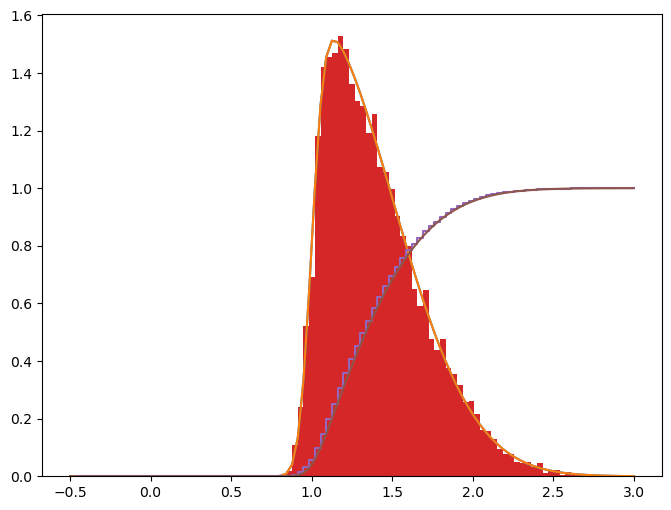

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
x_plot = np.linspace(-0.5,3, 100)
spstat_rv = spystats.skewnorm(8, 1, 0.5)
my_rv = SkewNormal(1, 0.5, 8)
ax.plot(x_plot, jnp.exp(spstat_rv.logpdf(x_plot)))
ax.plot(x_plot, jnp.exp(my_rv.log_prob(x_plot)))
ax.hist(my_rv.sample(jax.random.PRNGKey(42), sample_shape=(10000,)), density=True, bins=x_plot)
skew_hist = ax.hist((SkewNormal(0, 1, 8).sample(jax.random.PRNGKey(42), sample_shape=(10000,))*0.5+1), density=True, bins=x_plot)
empirical_cdf = jnp.cumsum(skew_hist[0])
ax.step(x_plot[1:], empirical_cdf/empirical_cdf[-1])
ax.plot(x_plot, my_rv.cdf(x_plot))
plt.show()

In [10]:
@jit
def fano_ER(mean_N_q, E_field, density):
    """
    Calculates the a Fano-like factor to determine the variance of quanta generation.

    Parameters
    ----------
    mean_N_q : scalar or array
        Mean number of quanta produced per event.
    E_field : scalar or array
        Electric field strength in the detector.
    density : scalar or array
        Density of the detector material.

    Returns
    -------
    Fano factor : scalar or array
        The calculated Fano factor based on the input parameters.
    
    """

    return (0.13 - 0.030*density - 0.0057*density**2 + 0.0016*density**3 + 0.0015*jnp.sqrt(mean_N_q*E_field))

In [11]:
@partial(jax.jit, static_argnums=(1,2,3,4))
def workfunction(density, molar_mass=131.293, avo=6.02214076e23, atom_num=54, old_13eV=1.1716263232):
    alpha = 0.067366 + density * 0.039693
    eDensity = (density / molar_mass) * avo * atom_num
    return old_13eV*(18.7263 - 1.01e-23 * eDensity), alpha

In [12]:
def calculate_yield_parameters(E_field):
    m01 = 30.66 + (6.1978 - 30.66) / (1. + (E_field / 73.855)**2.0318)**0.41883
    m02 = 77.2931084
    m03 = jnp.log10(E_field) * 0.13946236 + 0.52561312
    m04 = 1.82217496 + (2.82528809 - 1.82217496) / (1. + (E_field / 144.65029656)**-2.80532006)
    # m05 = Nq / energy / (1. + alpha * erf(0.05 * E)) - m01
    m07 = 7.02921301 + (98.27936794 - 7.02921301) / (1. + (E_field / 256.48156448)**1.29119251)
    m08 = 4.285781736
    m09 = 0.3344049589
    m10 = 0.0508273937 + (0.1166087199 - 0.0508273937) / (1. + (E_field / 1.39260460e+02)**-0.65763592)
    return m01, m02, m03, m04, m07, m08, m09, m10

In [13]:
@jit
def get_yields_beta(E, density, exciton_ion_ratio, W, m01=7.096208, m02=77.2931084, m03=0.7155229, m04=1.8279102, m07=94.39740941928082, m08=4.285781736, m09=0.3344049589, m10=0.06623858):
    """
    Calculates the yields of quanta, electrons and photons for beta radiation in a detector.

    Parameters
    ----------
    E : scalar or array
        Energy of the incident beta radiation.
    density : scalar or array
        Density of the detector material.
    exciton_ion_ratio : scalar
        Ratio of excitons to ions produced in the detector.
    W : scalar
        Average energy required to produce an electron-ion pair.
    m01, m02, m03, m04, m07, m08, m09, m10 : scalars
        Parameter values used in the empirical formula for calculating yields.

    Returns
    -------
    mean_N_q : scalar or array
        Mean number of quanta produced per event.
    Ne : scalar or array
        Number of electrons produced.
    Nph : scalar or array
        Number of photons produced.

    Notes
    -----
    This function calculates the yields of quanta, electrons and photons produced by beta radiation 
    in LXe based on the energy of the incident radiation, the density of the detector material, 
    and the ratio of excitons to ions produced.
    """
    m05 = 1/W/(1 + exciton_ion_ratio) - m01
    Qy = m01 + (m02 - m01) / ((1. + (E / m03)**m04))**m09 + m05 + (0.0 - m05) / ((1. + (E / m07)**m08))**m10
    mean_N_q = E/W*1e3
    Ly = mean_N_q / E - Qy
    Ne = Qy * E
    Nph = Ly * E
    return mean_N_q, Ne, Nph

In [14]:
workfunction(2.862)

(Array(13.55174716, dtype=float64, weak_type=True),
 Array(0.18096737, dtype=float64, weak_type=True))

In [15]:
calculate_yield_parameters(100)

(14.886655774004309,
 77.2931084,
 Array(0.80453784, dtype=float64),
 2.0849941919488195,
 77.41835364537435,
 4.285781736,
 0.3344049589,
 0.08015046785739921)

In [16]:
def Nei_ratio(E, density, alpha):
    """
    Calculates the ratio of the number of electrons to ions for a given energy and material density.

    Parameters
    ----------
    E : scalar or array
        Energy of the incident radiation.
    density : scalar or array
        Density of the detector material.

    Returns
    -------
    Nei_ratio : scalar or array
        The ratio of the number of electrons to ions.

    Notes
    -----
    This function calculates the ratio of the number of electrons to ions produced by 
    ERs.
    """

    return alpha*erf(0.05*E)

In [17]:
18.7263 - 1.01e-23*(2.86/131.293*6.022e23*54)

11.57178257104339

In [18]:
@jit
def recom_omega_ER(E_field, elecFrac, width_param_7=0.046452, width_param_8=0.205, width_param_9=0.45, width_param_10=-0.2):
    '''
    This function calculates the omega parameter for electron recoil (ER) events based on certain input parameters.
    
    Parameters
    ----------
    E_field : float 
        The electric field value.
    elecFrac : float 
        The fraction of energy deposited by electrons.
    width_param_7 : float, optional 
        Parameter A from Table VI of https://arxiv.org/pdf/2211.10726.pdf; default is 0.046452.
    width_param_8 : float, optional 
        Omega parameter from Table VI of https://arxiv.org/pdf/2211.10726.pdf; default is 0.205.
    width_param_9 : float, optional 
        Xi parameter from Table VI of https://arxiv.org/pdf/2211.10726.pdf; default is 0.45.
    width_param_10 : float, optional 
        Skewness parameter; default is -0.2.

    Returns
    -------
    omega : float 
        The calculated omega parameter for ER events.
    width_param_10 : float 
        The skewness parameter.

    Notes
    -----
    The function uses the provided parameters to calculate the value of omega for ER events. It also returns the skewness parameter.
    '''
    A = 0.086036 + (width_param_7 - 0.086036) / (1 + (E_field/295.2)**251.6)**0.0069114
    wide = width_param_8
    cntr = width_param_9
    skew = width_param_10
    mode = cntr + 2 * (inv_sqrt2_PI) * skew * wide / jnp.sqrt(1. + skew * skew)
    norm = 1. / (jnp.exp(-0.5 * (mode - cntr)**2 / (wide * wide)) * (1. + erf(skew * (mode - cntr) / (wide * sqrt2))))
    omega = norm * A * jnp.exp(-0.5 * (elecFrac - cntr)**2 / (wide * wide)) * (1. + erf(skew * (elecFrac - cntr) / (wide * sqrt2)))
    return omega, width_param_10


In [19]:
@partial(jax.jit, static_argnums=(1))
def ER_skew(E, E_field, alpha0=1.39, cc0=4.0, cc1=22.1, E0=7.7, E1=54., E2=26.7, E3=6.4, F0=225., F1=71.):
    if E_field < 50 or E_field > 1e4:
        return 0.0
    else:
        return 1. / (1. + jnp.exp((E - E2) / E3)) * (alpha0 + cc0 * jnp.exp(-1. * E_field / F0) * (1. - jnp.exp(-1. * E / E0))) + 1. / (1. + jnp.exp(-1. * (E - E2) / E3)) * cc1 * jnp.exp(-1. * E / E1) * jnp.exp(-1. * jnp.sqrt(E_field) / jnp.sqrt(F1))

In [20]:
ER_skew(100,100)

Array(1.05862738, dtype=float64, weak_type=True)

In [21]:
@partial(jax.jit, static_argnums=(1, 2))
def marginalized_prob_quantas(E, E_field=23.0, density=2.8619, Nq_bins = jnp.arange(1,1400)-0.5, Nq_bins_centers=jnp.arange(1,1399), Ni_bin_centers=jnp.arange(1,900), Ne_bins=(jnp.linspace(-0,399,400)-0.5)):
    '''
    $p(N_q, N_i, N_e | E, \theta)$
    Note: plate dim is righmost, specify in numpyro.
    dimensions: Ne, Ni, Nq, plate/batch dim
    '''
    W, alpha = workfunction(density)
    m01, m02, m03, m04, m07, m08, m09, m10 = calculate_yield_parameters(E_field)
    exciton_ion_ratio = Nei_ratio(E, density, alpha)
    mean_N_q, mean_Ne, mean_Nph = get_yields_beta(E, density, exciton_ion_ratio, W, m01=m01, m02=m02, m03=m03, m04=m04, m07=m07, m08=m08, m09=m09, m10=m10)
    # fano_factor = fano_ER(mean_N_q, E_field, density)
    fano_factor = 1 #For some reason fano got turned off in the latest NEST?
    Nq_ps = DiscreteNormalPs(mean_N_q, jnp.sqrt(fano_factor*mean_N_q), bin_edges=Nq_bins)
    alf = 1/(1 + exciton_ion_ratio)
    Ni_ps = stats.binom.pmf(n=Nq_bins_centers[jnp.newaxis, :,jnp.newaxis], p=alf, k=Ni_bin_centers[:, jnp.newaxis, jnp.newaxis])
    # Ni_ps = Ni_ps/jnp.sum(Ni_ps, axis=0)
    # Nq_Ni_ps = Nq_ps[:,jnp.newaxis,:] * Ni_ps

    e_frac = mean_Ne/mean_N_q
    recombProb = 1. - (exciton_ion_ratio + 1.) * e_frac
    recomb_omega, _ = recom_omega_ER(E_field, e_frac)
    skewness = ER_skew(E, E_field)
    # skewness = 10.
    recomb_variance = recombProb*(1 - recombProb)*Ni_bin_centers[:, jnp.newaxis, jnp.newaxis] + (recomb_omega*Ni_bin_centers[:, jnp.newaxis, jnp.newaxis])**2
    widthCorrection = jnp.sqrt(1. - (2. / jnp.pi) * skewness * skewness / (1. + skewness * skewness))
    muCorrection = (jnp.sqrt(recomb_variance) / widthCorrection) * (skewness / jnp.sqrt(1. + skewness * skewness)) * 2. * inv_sqrt2_PI
    Ne_mu = (1. - recombProb) * Ni_bin_centers[:, jnp.newaxis, jnp.newaxis] - muCorrection
    Ne_sigma = jnp.sqrt(recomb_variance) / widthCorrection
    # import pdb; pdb.set_trace()
    Ne_ps = DiscreteSkewNormalPs(Ne_mu, Ne_sigma, skewness, bin_edges=Ne_bins[:,jnp.newaxis,jnp.newaxis])
    # Ne_ni_nq_ps = Ne_ps*Ni_ps*Nq_ps
    return Ne_ps, Ni_ps, Nq_ps
    # return Ne_mu, Ne_sigma, skewness

    

In [2]:
import nestpy

In [5]:
nestpy.__nest_version__

'2.3.12'

In [22]:
marg_prob_Ne, marg_prob_Ni, marg_prob_Nq = marginalized_prob_quantas(jnp.array([5.,8.,15.]), E_field=100.0)
# jnp.unravel_index(jnp.argmax(marg_probs), marg_probs.shape)

In [23]:
# %%timeit
# marg_probs = marginalized_prob_quantas(jnp.array([5.,8.,15.]), E_field=100.0)

In [24]:
marg_prob_Nq.shape

(1398, 3)

In [25]:
# marg_probs = marg_prob_Ne*marg_prob_Ni*marg_prob_Nq

In [26]:
12035135952/1e9

12.035135952

In [27]:
marg_prob_Nq

Array([[4.49638609e-082, 3.02996404e-130, 1.52283740e-242],
       [1.21701603e-081, 8.21425636e-130, 4.13358942e-242],
       [3.28512679e-081, 2.22312269e-129, 1.12100822e-241],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],      dtype=float64)

In [28]:
# marg_probs.shape

In [29]:
# marg_probs

In [30]:
# jnp.sum(marg_probs[:,:,:,1])

In [31]:
#generate some simulated data using nestpy

import nestpy
detector = nestpy.VDetector()

In [32]:
detector.get_eLife_us()

2200.0

In [33]:
detector.get_dt_max()

60.0

In [34]:
A = 131.293 # avg atomic mass of Xe
Z = 54. # Atomic number of Xe 

nc = nestpy.NESTcalc(detector)

density = nc.GetDensity( T=detector.get_T_Kelvin(), P=detector.get_p_bar(), inGas=False )
print( "Using detector's LXe density, %.3f g/cc" % density)

Using detector's LXe density, 2.861 g/cc


In [35]:
density

2.8611000581216786

In [36]:
nc.WorkFunction(density).Wq_eV

13.554384684687134

In [37]:
@np.vectorize
def GetQuanta(interaction=nestpy.beta, 
              energy=100., # energy in keV of the recoil itself
              drift_field=100.): # V/cm
    
    #What's first done in nestpy is getting the yields 
    #Based on the arguments below; most important, energy, density, field.
    #To see the spectrum of these, see nest.ucdavis.edu/benchmarkplots 
    y = nc.GetYields(interaction,
     energy,
     density,
     drift_field,
     A,
     Z,
    ) 
    # Then we call nestcalc class' function, GetQuanta 
    quanta = nc.GetQuanta(y, density)
    photons, electrons = quanta.photons, quanta.electrons

    return photons, electrons

In [38]:
test_E = jnp.array([8]*5000)
g1 = 0.105
g2 = 17.3
SE_gain = 31.8
extraction_eff = g2/SE_gain
PMT_sigma = 0.8
S2_sigma=26

In [39]:
Nph_nest, Ne_nest = GetQuanta(energy=test_E)

In [40]:
Ne_nest

array([196, 187, 184, ..., 238, 278, 189])

In [41]:
# marg_prob_Ne*marg_prob_Ni*marg_prob_Nq

In [42]:
marg_prob_Nq.shape

(1398, 3)

In [43]:
# jnp.sum(marg_prob_Nq * marg_prob_Ni, axis=(1))

In [44]:
marg_prob_Ni.shape

(899, 1398, 3)

In [45]:
marg_prob_Ne.shape

(399, 899, 1, 3)

In [46]:
marg_prob_Ni.shape

(899, 1398, 3)

In [47]:
marg_prob_Ne[:,:,0,:].shape

(399, 899, 3)

In [48]:
(marg_prob_Ne[:,:,0,:]*jnp.sum(marg_prob_Nq * marg_prob_Ni, axis=(1))).shape

(399, 899, 3)

In [49]:
marg_prob_Ni[jnp.newaxis, :, :, :].shape

(1, 899, 1398, 3)

In [50]:
marg_prob_Ne.shape

(399, 899, 1, 3)

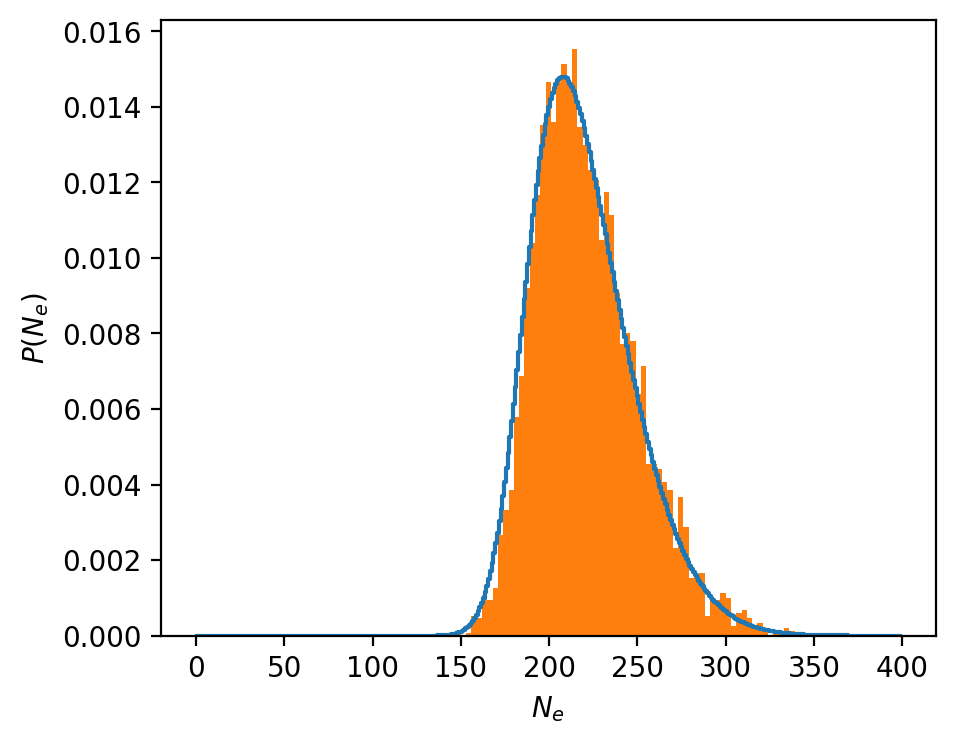

In [51]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
plt_x = jnp.linspace(1,399,399, dtype=jnp.float32)-0.5
# ax.step(plt_x, jnp.sum(marg_probs[:,:,:,1], axis=(1,2)))
# ax.step(plt_x, jnp.einsum('ijk,ijk,ijk  -> i', marg_prob_Ne[:,:,:,1], marg_prob_Nq[jnp.newaxis, jnp.newaxis, :, 1], marg_prob_Ni[jnp.newaxis, :, :, 1]))
ax.step(plt_x, jnp.sum(marg_prob_Ne[:,:,0,:]*jnp.sum(marg_prob_Nq * marg_prob_Ni, axis=(1)), axis=(1))[:,1])
ax.hist(Ne_nest, density=True, bins=jnp.arange(0,400,3))
ax.set(xlabel=r'$N_e$', ylabel='$P(N_e)$')
plt.show()

In [52]:
Ni_bins_centers = jnp.arange(1,1399)
Ni_ps = jnp.zeros_like(Ni_bins_centers)
# summed_marg_prob = jnp.sum(marg_probs[:,:,:,1], axis=(1))
summed_marg_prob = jnp.triu(jnp.einsum('ijk,ijk,ijk  -> ik', marg_prob_Ne[:,:,:,1], marg_prob_Nq[jnp.newaxis, jnp.newaxis, :, 1], marg_prob_Ni[jnp.newaxis, :, :, 1]))

In [53]:
@jit
def calculate_Ni_prob_inner_loop(j, i, summed_marg_prob, Ni_bins_centers):
    Ni_ps = jnp.zeros_like(Ni_bins_centers, dtype=float)
    return Ni_ps.at[j-i].set(summed_marg_prob[i, j] + Ni_ps[j-i])

In [54]:
calculate_Ni_prob_inner_loop_vmap = jax.vmap(calculate_Ni_prob_inner_loop, in_axes=(0, None, None, None))

In [55]:
@jit
def calculate_Ni_prob_outer_loop(i, summed_marg_prob, Ni_bins_centers):
    return jnp.sum(calculate_Ni_prob_inner_loop_vmap(jnp.arange(1398), i, jnp.triu(summed_marg_prob), Ni_bins_centers), axis=0)

In [56]:
%%timeit
calculate_Ni_prob_outer_loop(1, summed_marg_prob, Ni_bins_centers)

156 µs ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
calculate_Ni_prob_outer_loop(1, summed_marg_prob, Ni_bins_centers).shape

(1398,)

In [58]:
calculate_Ni_prob_outer_loop_vmap = jax.vmap(calculate_Ni_prob_outer_loop, in_axes=(0, None, None,))

In [59]:
calculate_Ni_prob_outer_loop_vmap(jnp.arange(12), jnp.triu(summed_marg_prob), Ni_bins_centers).shape

(12, 1398)

In [60]:
@jit
def compute_Ni_ps(summed_marg_prob, Ni_bins_centers):
    Ni_ps = jnp.zeros_like(Ni_bins_centers, dtype=float)
    for i in jnp.arange(399):
        Ni_ps += jnp.sum(calculate_Ni_prob_inner_loop_vmap(jnp.arange(0, 1398), i, (summed_marg_prob), Ni_bins_centers), axis=0)
    return Ni_ps

In [61]:
%%timeit
compute_Ni_ps(summed_marg_prob, Ni_bins_centers)

447 µs ± 50.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
Ni_ps = compute_Ni_ps(summed_marg_prob, Ni_bins_centers)

In [63]:
%prun compute_Ni_ps(summed_marg_prob, Ni_bins_centers)

         3 function calls in 0.007 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.007    0.007    0.007    0.007 <string>:1(<module>)
        1    0.000    0.000    0.007    0.007 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [64]:
jnp.sum(Ni_ps)

Array(0.99999759, dtype=float64)

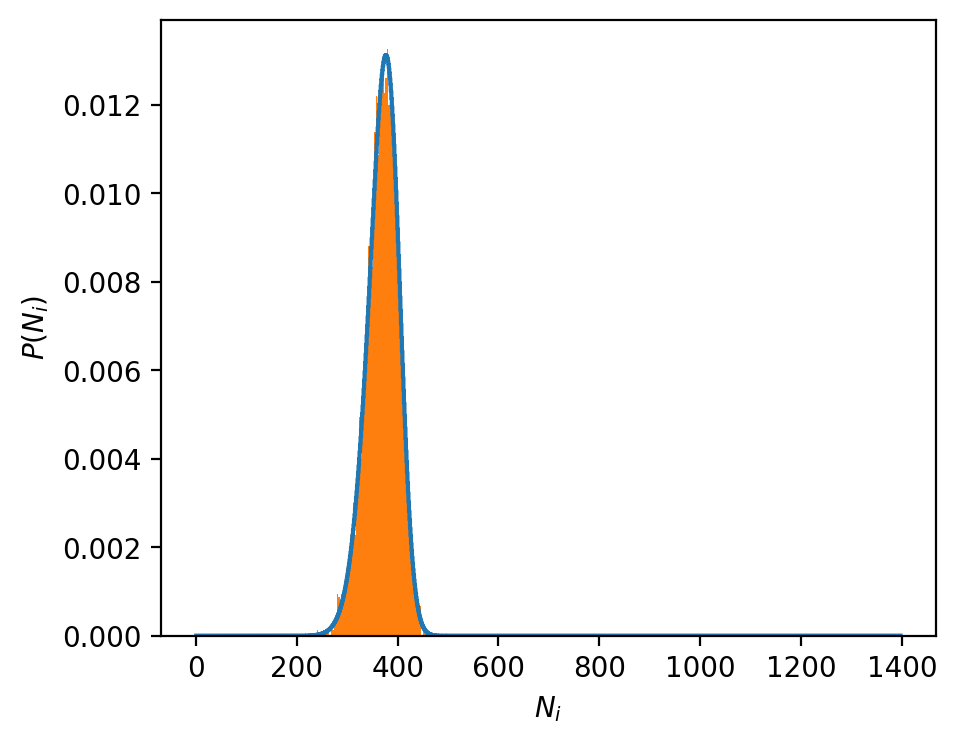

In [65]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
plt_x = jnp.linspace(1,1398,1398, dtype=jnp.float32)-0.5
ax.step(plt_x, Ni_ps)
ax.hist(Nph_nest, density=True, bins=jnp.arange(0,500,3))
ax.set(xlabel=r'$N_i$', ylabel='$P(N_i)$')
plt.show()

In [81]:
a = [1,2,3,4,5]*100
b = [1,2,3,4,5]*100

In [82]:
%%timeit
c = []
for i in range(len(a)):
    c.append(a[i]+b[i])

19.7 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [83]:
%%timeit
c = [a[i] + b[i] for i in range(len(a))]

19.1 µs ± 277 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [84]:
%%timeit
c = list(map(sum, zip(a, b)))

32.5 µs ± 153 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
